<div>
    <h1 style="margin-top: 50px; font-size: 33px; text-align: center"> Homework 4 </h1>
    <br>
    <div style="font-weight:200; font-size: 20px; padding-bottom: 15px; width: 100%; text-align: center;">
        <right>Fabio Montello, Maria Luisa Croci, Eltaj Babanli</right>
        <br>
    </div>
    <hr>
</div>

<div>
    <h1 style="margin-top: -5px; font-size: 20px; text-align: center"> 1) Does basic house information reflect house' s description? </h1>
    <br>
</div>

### Scraping

In [417]:
import threading
import requests
import random
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
import string
import libclust
import findspark
import pyspark
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup

In this section all the info about the houses are extract from the the following website https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1

In [412]:
immobiliare = requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1")
page = BeautifulSoup(immobiliare.text, "html5lib")
n = page.find_all("span", class_ = "pagination__label")
n = n[len(n) - 1] #last element
n = int(n.getText())
n #number of pages for taking the information

1729

In [ ]:
links = []
notdw = []

In [ ]:
#The following function helps to make the scraping on each link
def getLinksFromPage(url):
    time.sleep(round(random.uniform(0.01, 0.4), 2))
    try:
        immobiliare = requests.get(url)
    except:
        notdw.append(url)
        return
    result = BeautifulSoup(immobiliare.text, "html5lib")
    x = result.find_all("p", class_ = "titolo")
    
    links.extend([item.find('a').get('href') for item in x if item.find('a').get('href').startswith("https://www.immobiliare.it/")])


In [ ]:
#in order to download faster the data we use threads that parallelize the procedure
threads = []
    
for i in range(n): #n
    url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=" + str(i + 1)
    t = threading.Thread(target=getLinksFromPage, args=(url,))
    threads.append(t)
    t.start()

In [ ]:
def areThreadsAlive(threads):
    for thread in threads:
        if(thread.isAlive() == True):
            return "Not finished yet"
    
    return "All threads are completed"

In [ ]:
#save a txt file with all the urls
linkfile = open('data/links.txt', 'w')
for link in links:
    linkfile.write("%s\n" % link)
linkfile.close()

In [ ]:
#extract the features for each apartment
#we consider only apartments that have all the features

feautures = []
descr = []
notdw = []
def getDataFromLinks(i, url):
    time.sleep(round(random.uniform(0.01, 0.4), 2))
    # Get the webpage
    try:
        info = requests.get(url)
    except:
        notdw.append(url)
        return
    info = BeautifulSoup(info.text, "html5lib")
    
    # Get the feauters needed
    feauts = info.find_all("div", class_ = "im-property__features")
    feautList = [item.find_all("span") for item in feauts]  
    listfeautures = info.find("ul", class_ = "features__list")
    try:
        
        price = info.find_all("li", class_ = "features__price")[0].find('span', recursive=False).getText()
        
        room = None
        bathroom = None
        floor = None
        surface = None

        for elem in listfeautures.findAll('li'):
            if str(elem).find("locali") != -1:
                room = elem.find('span').getText()

            elif (str(elem).find("bagni") != -1):
                bathroom = elem.find('span').getText()

            elif (str(elem).find("piano") != -1):
                floor = elem.find('abbr').getText()

            elif (str(elem).find("superficie") != -1):
                surface =  elem.find('span').getText()

            if((room is not None) and\
               (bathroom is not None) and\
               (floor is not None) and\
               (surface is not None)):
            # Get the description 
                descr.extend([[url, info.find_all("div", class_ = "description-text")[0] \
                       .getText()\
                       .replace('\n', ' ')\
                       .replace('                                              ', '')\
                       .replace('                      ','')\
                      ]])
                feautures.extend([[url, price, room, surface, bathroom, floor]])

    except:
        return

In [ ]:
threads = []

for i, url in enumerate(links):
    t = threading.Thread(target=getDataFromLinks, args=(i,url,))
    threads.append(t)
    t.start()

In [ ]:
#convert as data frame in order to save 
#matrix of the features
dfFe = pd.DataFrame(feautures, columns = ["Url", "Price", "Room", "Surface", "Bathroom", "Floor"])
#matrix of the descriptions
dfDe = pd.DataFrame(descr, columns = ["Url", "Descr"])

In [ ]:
dfFe.isnull().sum()

In [ ]:
dfFe.to_csv('data/feautures.csv', sep=',', na_rep='') 

In [ ]:
dfDe.to_csv('data/descriptions.csv', sep=',', na_rep='')

### Datasets

1) **INFORMATION**   
The dataframe "dfFe" is the matrix $m_{i,j} = value$ where $i=0,...,n$ is the announcement and $j$ is "price", "locali", "superficie", "bagni", "piano"

In [41]:
dfDe = pd.read_csv('data/descriptions.csv', index_col = 0)
dfFe = pd.read_csv('data/feautures.csv', index_col = 0)

In [42]:
dfFe.head()

Url      Price Room  Surface  \
0  https://www.immobiliare.it/69032803-Vendita-Bi...  € 169.000   2      72.0   
1  https://www.immobiliare.it/69032803-Vendita-Bi...  € 169.000   2      72.0   
2  https://www.immobiliare.it/69783036-Vendita-At...  € 520.000   4     120.0   
3  https://www.immobiliare.it/69783036-Vendita-At...  € 520.000   4     120.0   
4  https://www.immobiliare.it/60154116-Vendita-Mo...  € 195.000   1      38.0   

  Bathroom     Floor  
0       1   T     \n  
1       1   T     \n  
2       3   A     \n  
3       3   A     \n  
4       1   1     \n

In [44]:
set(dfFe['Floor']) #see which floor we have and replace the letters with numbers

{'10\xa0    \n',
 '11+\xa0    \n',
 '1\xa0    \n',
 '2\xa0    \n',
 '3\xa0    \n',
 '4\xa0    \n',
 '5\xa0    \n',
 '6\xa0    \n',
 '7\xa0    \n',
 '8\xa0    \n',
 '9\xa0    \n',
 'A\xa0    \n',
 'R\xa0    \n',
 'S\xa0    \n',
 'T\xa0    \n'}

In [47]:
pd.options.mode.chained_assignment = None  # default='warn'
dfFe = dfFe.replace(r'\  \n',' ', regex=True).replace(r'\xa0', '').replace(r'\s+', '', regex=True)
dfFe.Price =  pd.to_numeric(dfFe.Price\
                            .replace('€ ', '')\
                            .replace("[^0-9]", '', regex = True))

#All ads with more than 5 rooms, now will become 6 instead of 5+
dfFe.Room =   pd.to_numeric(dfFe.Room.replace('5\+', '6').replace("[^0-9]", '', regex = True)) 

#All ads with more than 3 bathroome, now will become 4 instead of 3+
dfFe.Bathroom =  pd.to_numeric(dfFe.Bathroom.replace('3\+', '4').replace("[^0-9]", '', regex = True))

dfFe.Surface =  pd.to_numeric(dfFe.Surface.replace("[^0-9]", '', regex = True))
dfFe.Floor =  pd.to_numeric(dfFe.Floor.replace('11+', '11')
                            .replace('A', '12')\
                            .replace('R', '1')\
                            .replace('S', '-1')\
                            .replace('T', '0'))


In [48]:
dfFe.head()

Url     Price  Room  Surface  \
0  https://www.immobiliare.it/69032803-Vendita-Bi...  169000.0     2     72.0   
1  https://www.immobiliare.it/69032803-Vendita-Bi...  169000.0     2     72.0   
2  https://www.immobiliare.it/69783036-Vendita-At...  520000.0     4    120.0   
3  https://www.immobiliare.it/69783036-Vendita-At...  520000.0     4    120.0   
4  https://www.immobiliare.it/60154116-Vendita-Mo...  195000.0     1     38.0   

   Bathroom  Floor  
0         1      0  
1         1      0  
2         3     12  
3         3     12  
4         1      1

In [50]:
dfFe.isnull().sum()

Url           0
Price       117
Room          0
Surface       0
Bathroom      0
Floor         0
dtype: int64

In [51]:
dfFe = dfFe.dropna() #drop rows with na values

In [52]:
dfFe.isnull().sum()

Url         0
Price       0
Room        0
Surface     0
Bathroom    0
Floor       0
dtype: int64

In [54]:
dfFe = dfFe.drop_duplicates(subset=None, keep='first', inplace=False) #remove equals rows

In [55]:
dfFe.to_csv('data/feauturesCleaned.csv', sep=',', na_rep='')

dfFe = pd.read_csv('data/feauturesCleaned.csv', sep=',', index_col=0)
dfFe.head()

Url     Price  Room  Surface  \
0  https://www.immobiliare.it/69032803-Vendita-Bi...  169000.0     2     72.0   
2  https://www.immobiliare.it/69783036-Vendita-At...  520000.0     4    120.0   
4  https://www.immobiliare.it/60154116-Vendita-Mo...  195000.0     1     38.0   
6  https://www.immobiliare.it/60679448-Vendita-Bi...  195000.0     2     60.0   
8  https://www.immobiliare.it/70373906-Vendita-Tr...  279000.0     3     73.0   

   Bathroom  Floor  
0         1      0  
2         3     12  
4         1      1  
6         1      1  
8         1     12

In [56]:
idx = dfDe.index.intersection(dfFe.index)

dfDe = dfDe.iloc[idx]

Check if they have the same length:

In [57]:
len(dfDe)

9545

In [58]:
len(dfFe)

9545

In [59]:
descr = [elem for elem in dfDe['Descr']]
descr

['Rif: 1653461 - CENTOCELLE in Via Tor de Schiavi, appartamento posto al piano terra con giardino.  Appartamento di Mq 72 c.a. composto da: Ingresso, Soggiorno, Cucina Abitabile, Camera Matrimoniale, Bagno, Giardino di Mq 50 c.a.  In discreto stato con infissi nuovi e pavimentazione del giardino recentemente sostituita.  Affaccio interno, NO su strada.',
 'Rif: VR/618 - Rifiutata proposta a €440,000  Proponiamo in esclusiva splendido attico e superattico nel signorile comprensorio di via Monte Amiata, nel cuore del quartiere Nuovo Salario/Prati Fiscali, a poca distanza dalla nuova Stazione capolinea della Metro B1 Jonio che collega direttamente al centro di Roma.  Si può accedere al comprensorio di Via monte Amiata sia da Prati Fiscali (pedoni ed autovetture) sia da Piazza Dante Gallani (pedoni), permettendo di raggiungere scuole, negozi e servizi comodamente a piedi.  L’architettura del rinomato comprensorio, di recente costruzione, spicca nell’intero quartiere per originalità ed eleg

In [61]:
nltk.download("stopwords")
stopwords = stopwords.words('italian')
st = nltk.stem.SnowballStemmer("italian")
def clean(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    doc = tokenizer.tokenize(doc) #tokenize the query for stop word and punctuation
    doc = [t for t in doc if t not in stopwords and t.isalpha()] #remove stopword
    doc = [st.stem(word) for word in doc] #stemming
    
    return doc



#tostem = ([x.lower() for x in text.split(' ') if x.lower() not in stopwords.words(languages[lan]) and x.isalpha()])
#docdict[i] = [nltk.stem.SnowballStemmer(languages[lan]).stem(word) for word in tostem]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2) **DESCRIPTION**   
The dataframe "adjacency" is the matrix $m_{i,j} = tfIdf_{i,j}$ where $i=1,...,n$ and $j$ is $"word_1", "word_2", ..., "word_m"$

What we need now is to calculate che IDF and TF - IDF, according to the formulas: 
- $TF = \frac{N_{(x,y)}}{N_{(*,y)}}$
- $IDF = log[1 + (\frac{D}{D_x})]$ <fr>

Where:
- $N_{(x,y)}$ is the number of times that the word $X$ is in the document $D_y$;
- $N_{(*,y)}$ is the total number of the words in the document;
- $D$ is the total number of documents;
- $D_x$ is the number of documents in which the word $X$ appears at least once.

For calculating the tf-idf we start from an empty data frame called "adjacency" that contains 1 if a word appears in an announcement and 0 viceversa. 
Then we create the tf_idf function that will compute the tfidf, given some parameters as input:

- "word" the word we are interested in calculating the frequency
- "doc" the text we want to evaluate the frequency of the word
- "D" the total number of announcements (a constant value)
- "N" the number of announcements containig that word.

In [62]:
aa = []
for i in descr:
    aa += [clean(i)]

In [420]:
aa #nested list with tokenizer and stopwords for each description of each announcement

[['rif',
  'centocell',
  'via',
  'tor',
  'de',
  'schi',
  'appart',
  'post',
  'pian',
  'terr',
  'giardin',
  'appart',
  'mq',
  'compost',
  'ingress',
  'soggiorn',
  'cucin',
  'abit',
  'camer',
  'matrimonial',
  'bagn',
  'giardin',
  'mq',
  'in',
  'discret',
  'stat',
  'infiss',
  'nuov',
  'paviment',
  'giardin',
  'recent',
  'sostitu',
  'affacc',
  'intern',
  'no',
  'strad'],
 ['rif',
  'vr',
  'rifiut',
  'propost',
  'propon',
  'esclus',
  'splendid',
  'attic',
  'superatt',
  'signoril',
  'comprensor',
  'via',
  'mont',
  'ami',
  'cuor',
  'quart',
  'nuov',
  'salar',
  'prat',
  'fiscal',
  'poc',
  'distanz',
  'nuov',
  'stazion',
  'capoline',
  'metr',
  'jon',
  'colleg',
  'dirett',
  'centr',
  'rom',
  'si',
  'può',
  'acced',
  'comprensor',
  'via',
  'mont',
  'ami',
  'prat',
  'fiscal',
  'pedon',
  'autovettur',
  'piazz',
  'dant',
  'gallan',
  'pedon',
  'permett',
  'raggiung',
  'scuol',
  'negoz',
  'serviz',
  'comod',
  'pied',


In [63]:
cc = set([i for item in aa for i in item])
cc #set of alla distinct words in aa

{'lunimos',
 'cross',
 'stratific',
 'avicenn',
 'fornir',
 'rotond',
 'minister',
 'gregorioxii',
 'coanim',
 'maximil',
 'edacon',
 'customer',
 'bresadol',
 'ottemper',
 'clet',
 'quadrfamigl',
 'rigener',
 'annunziatell',
 'cas',
 'plan',
 'ercol',
 'lcentr',
 'nb',
 'eingangshall',
 'consil',
 'seriv',
 'presis',
 'coup',
 'corrispondent',
 'gattesc',
 'scopert',
 'soffr',
 'fior',
 'official',
 'regolarizz',
 'mancanz',
 'approssim',
 'avverr',
 'riacquist',
 'educ',
 'asciutt',
 'certification',
 'sciamann',
 'studentess',
 'tarrazz',
 'pagnott',
 'sezion',
 'lussemburg',
 'mercant',
 'bandin',
 'nemmen',
 'sin',
 'redd',
 'imprescind',
 'gelater',
 'belmont',
 'iticas',
 'lei',
 'carin',
 'assest',
 'nereid',
 'ciocc',
 'zogn',
 'aeroport',
 'gartu',
 'tiberin',
 'sfogg',
 'batt',
 'massagg',
 'titolar',
 'vimerc',
 'specc',
 'pozz',
 'ramazzin',
 'cablagg',
 'occidental',
 'selm',
 'fabr',
 'teak',
 'pierfrancesc',
 'aspxhttp',
 'deal',
 'couples',
 'interpost',
 'semisfer',
 

In [64]:
tfidf = pd.DataFrame(columns = list(cc))

In [65]:
import math
def tf_idf(word,doc,D,N):
    f = doc.count(word) / len(doc)
    tfidf = math.log(D/N)*f
    
    return float(tfidf)

In [66]:
id_descr = {i : d for i,d in enumerate(descr)}

In [67]:
adjacency = pd.DataFrame(0, index = id_descr.keys(), columns = list(cc), dtype= float)

In [68]:
for i, k in enumerate(aa):
    for j in cc:
        if j in k:
            adjacency.at[i,j] = 1

In [70]:
count_word = adjacency.sum()

In [71]:
D = len(adjacency.index)
for i, k in enumerate(aa):
    for j in cc:
        if adjacency.at[i,j] == 1:
            adjacency.at[i,j] = tf_idf(j, k, D, count_word[j])
            #print(tf_idf(j, k, D, count_word[j]))

In [72]:
adjacency.head()

lunimos  cross  stratific  avicenn  fornir  rotond  minister  gregorioxii  \
0      0.0    0.0        0.0      0.0     0.0     0.0       0.0          0.0   
1      0.0    0.0        0.0      0.0     0.0     0.0       0.0          0.0   
2      0.0    0.0        0.0      0.0     0.0     0.0       0.0          0.0   
3      0.0    0.0        0.0      0.0     0.0     0.0       0.0          0.0   
4      0.0    0.0        0.0      0.0     0.0     0.0       0.0          0.0   

   coanim  maximil    ...      rior  vorbereitung  lucernar  rimast  \
0     0.0      0.0    ...       0.0           0.0       0.0     0.0   
1     0.0      0.0    ...       0.0           0.0       0.0     0.0   
2     0.0      0.0    ...       0.0           0.0       0.0     0.0   
3     0.0      0.0    ...       0.0           0.0       0.0     0.0   
4     0.0      0.0    ...       0.0           0.0       0.0     0.0   

   balconcin  izziimmobil  metropolit  disegn  fabriz  bernadett  
0        0.0          0.0         0.0     0.0     0.0        0.0  
1        0.0          0.0         0.0     0.0     0.0        0.0  
2        0.0          0.0         0.0     0.0     0.0        0.0  
3        0.0          0.0         0.0     0.0     0.0        0.0  
4        0.0          0.0         0.0     0.0     0.0        0.0  

[5 rows x 13229 columns]

The adjacency matrix at the end contains all the tf-idf for each word in each announcement.

### Clustering

In [74]:
tokmean = dfFe.drop(['Url'], axis=1)
tokmean.isnull().sum()

Price       0
Room        0
Surface     0
Bathroom    0
Floor       0
dtype: int64

In [75]:
tokmean.loc[(tokmean['Price'] > 10000000)]

Empty DataFrame
Columns: [Price, Room, Surface, Bathroom, Floor]
Index: []

In [82]:
k = 10
inertia = []
for i in range(k):
    inertia.append(KMeans(n_clusters=i + 1, random_state=0).fit(tokmean.values).score(tokmean.values))

inertia

[-1682753992149360.0,
 -787772834712187.9,
 -462584789171699.4,
 -285259730945496.1,
 -186007146260705.06,
 -134704761332303.83,
 -101794908521512.06,
 -77417666310060.62,
 -59028931447917.16,
 -48270677107762.23]

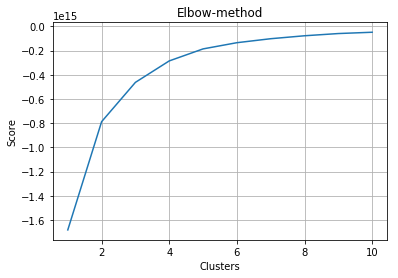

In [83]:
fig, ax = plt.subplots()
ax.plot([i+1 for i in range(k)],inertia)

ax.set(xlabel='Clusters', ylabel='Score',
       title='Elbow-method')
ax.grid()

A good choise of cluster is 4

In [84]:
dfFeClust = dfFe.dropna().copy()

In [85]:
len(dfFeClust)

9545

In [86]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(tokmean.values)
dfFeClust['Cluster'] = kmeans.labels_
kmeans.labels_

array([0, 3, 0, ..., 3, 1, 0], dtype=int32)

In [91]:
dfFeClust.head()

Url     Price  Room  Surface  \
0  https://www.immobiliare.it/69032803-Vendita-Bi...  169000.0     2     72.0   
2  https://www.immobiliare.it/69783036-Vendita-At...  520000.0     4    120.0   
4  https://www.immobiliare.it/60154116-Vendita-Mo...  195000.0     1     38.0   
6  https://www.immobiliare.it/60679448-Vendita-Bi...  195000.0     2     60.0   
8  https://www.immobiliare.it/70373906-Vendita-Tr...  279000.0     3     73.0   

   Bathroom  Floor  Cluster  
0         1      0        0  
2         3     12        3  
4         1      1        0  
6         1      1        0  
8         1     12        0

In [88]:
dimClusts = {}
for i in range(4):
    dimClusts[i] = len(dfFeClust.loc[(dfFeClust['Cluster'] == i)])
dimClusts

{0: 6987, 1: 441, 2: 40, 3: 2077}

In [89]:
kmeansD = KMeans(n_clusters=4, random_state=0).fit(adjacency.values)

In [103]:
dfDe['Cluster'] = kmeansD.labels_
dfDe.head()

Url  \
0  https://www.immobiliare.it/69032803-Vendita-Bi...   
2  https://www.immobiliare.it/69783036-Vendita-At...   
4  https://www.immobiliare.it/60154116-Vendita-Mo...   
6  https://www.immobiliare.it/60679448-Vendita-Bi...   
8  https://www.immobiliare.it/70373906-Vendita-Tr...   

                                               Descr  Cluster  
0  Rif: 1653461 - CENTOCELLE in Via Tor de Schiav...        2  
2  Rif: VR/618 - Rifiutata proposta a €440,000  P...        2  
4  Il progetto "Loft San Lorenzo" crea un connubi...        2  
6  Elegante appartamento in palazzina in cortina,...        1  
8  Rif: 534-18 - "VISITA SUBITO IL NOSTRO SITO WW...        2

For make easier the computation of the Jaccard Similarity (defined below) we create two dictionaries that contain which announcements belong to its cluster.

In [101]:
s = {}
for i in range(4):
    s[i] = list(dfDe.loc[dfDe.Cluster == i].index)
    

In [102]:
s 

{0: [228,
  470,
  655,
  658,
  782,
  1341,
  1351,
  1414,
  1759,
  1768,
  2021,
  2067,
  2318,
  2711,
  2721,
  2782,
  2823,
  2840,
  2856,
  2952,
  3043,
  3083,
  3095,
  3114,
  3115,
  3128,
  3138,
  3257,
  3259,
  3279,
  3306,
  3316,
  3335,
  3476,
  3541,
  3542,
  3546,
  3548,
  3889,
  3897,
  3900,
  3904,
  3975,
  3977,
  3979,
  3987,
  3994,
  3995,
  4005,
  4066,
  4084,
  4109,
  4112,
  4113,
  4121,
  4122,
  4124,
  4126,
  4128,
  4129,
  4156,
  4165,
  4170,
  4174,
  4175,
  4178,
  4179,
  4187,
  4193,
  4195,
  4199,
  4213,
  4216,
  4217,
  4230,
  4263,
  4264,
  4267,
  4286,
  4297,
  4334,
  4339,
  4342,
  4398,
  4500,
  4573,
  4574,
  4576,
  4577,
  4578,
  4581,
  4583,
  4584,
  4585,
  4591,
  4596,
  4606,
  4610,
  4612,
  4664,
  4674,
  4680,
  4683,
  4688,
  4694,
  4696,
  4698,
  4702,
  4705,
  4707,
  4766,
  4772,
  4773,
  4777,
  4779,
  4781,
  4785,
  4786,
  4830,
  4842,
  4843,
  4845,
  4846,
  4847,
  4849,
  

In [105]:
t = {}
for i in range(4):
    t[i] = list(dfFeClust.loc[dfFeClust.Cluster == i].index)


In [106]:
t

{0: [0,
  4,
  6,
  8,
  9,
  11,
  15,
  16,
  18,
  23,
  24,
  25,
  26,
  28,
  33,
  34,
  38,
  39,
  40,
  44,
  45,
  47,
  49,
  50,
  53,
  56,
  60,
  61,
  62,
  64,
  65,
  66,
  68,
  70,
  72,
  73,
  74,
  78,
  82,
  88,
  89,
  92,
  93,
  99,
  101,
  103,
  107,
  111,
  113,
  115,
  119,
  120,
  122,
  123,
  127,
  128,
  132,
  134,
  137,
  141,
  146,
  148,
  153,
  155,
  159,
  163,
  165,
  167,
  168,
  169,
  175,
  179,
  180,
  181,
  183,
  184,
  185,
  187,
  191,
  193,
  199,
  200,
  201,
  202,
  204,
  206,
  208,
  214,
  217,
  222,
  227,
  228,
  229,
  232,
  235,
  241,
  242,
  245,
  246,
  254,
  258,
  260,
  261,
  270,
  274,
  276,
  278,
  279,
  281,
  290,
  293,
  294,
  298,
  301,
  304,
  305,
  307,
  313,
  315,
  316,
  317,
  319,
  320,
  321,
  323,
  325,
  327,
  328,
  331,
  334,
  336,
  342,
  343,
  345,
  346,
  349,
  351,
  354,
  355,
  357,
  360,
  361,
  362,
  365,
  366,
  367,
  370,
  371,
  373,
  3

### Comparison among cluster
We expect that both datasets will lead to similar clusters. Is this true?

### Find similar clusters with Jaccard Similarity

$J(A,B) = \frac{|A\cap B|}{|A\cup B|}$ defined as the intersection over union of two sets and it's used for comparing the similarity and diversity of sample sets.

In [382]:
#jaccard similarity is ratio between intersection and union

js = []

for i in range(4):
    for j in range(4):
        a = len(set(s[i]).intersection(set(t[j])))
        b = len(set(s[i]).union(set(t[j])))
        js.append((a/b, i, j))
        
js

[(0.08123407868666856, 0, 0),
 (0.006439742410303588, 0, 1),
 (0.0, 0, 2),
 (0.02708803611738149, 0, 3),
 (0.17677595628415302, 1, 0),
 (0.017716535433070866, 1, 1),
 (0.003612281757977122, 1, 2),
 (0.08526223263990625, 1, 3),
 (0.5347329083315014, 2, 0),
 (0.05550021346235947, 2, 1),
 (0.0048696648524778, 2, 2),
 (0.2290252511539506, 2, 3),
 (0.03617203076046711, 3, 0),
 (0.0110803324099723, 3, 1),
 (0.0, 3, 2),
 (0.011543394613082514, 3, 3)]

In [299]:
#3-most similar couples of clusters
sorted(js, reverse = True)[:3]

[(0.5347329083315014, 2, 0),
 (0.2290252511539506, 2, 3),
 (0.17677595628415302, 1, 0)]

### Word cloud of house descriptions
With the 3 most higher JS we want to create 3 wordcloud with the words that appear more frequently.

In [239]:
#first intersection
inter_1 = set(s[2]).intersection(set(t[0]))

#second intersection
inter_2 = set(s[2]).intersection(set(t[3]))

#third intersection
inter_3 = set(s[1]).intersection(set(t[0]))



In [336]:
#extract the descriptions
def cloud(inter):
    cloud = []

    for i in inter_1:
        cloud.append(dfDe["Descr"][i])
        
    cloud = str(cloud)
    
    return cloud

In [337]:
cloud_1 = cloud(inter_1)
cloud_2 = cloud(inter_2)
cloud_3 = cloud(inter_3)

In [391]:
ita = [word for word in stopwords.words('italian')]
stopwords = set(STOPWORDS)
stopwords.update(ita)
stopwords.update(["proponiamo", "vendita", "zona", "circa", "mq", "rif"])

In [421]:
#we want to give it the shape of a house
house_mask = np.array(Image.open("house.png"))

In [361]:
# Transform your mask into a new one
transformed_house_mask = np.ndarray((house_mask.shape[0],house_mask.shape[1]), np.int32)

for i in range(len(house_mask)):
    for j in range(len(house_mask[i])):
        if house_mask[i][j].any() == 0:
            transformed_house_mask[i][j] = 255
    
    

In [399]:
def wordcloud_fun(cloud):
    wc = WordCloud(background_color="white", max_words=1000, mask=transformed_house_mask,
               stopwords=stopwords, contour_width=3, contour_color='black')
    
    # Generate a wordcloud
    wc.generate(cloud)
    
    # show
    plt.figure(figsize=[20,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


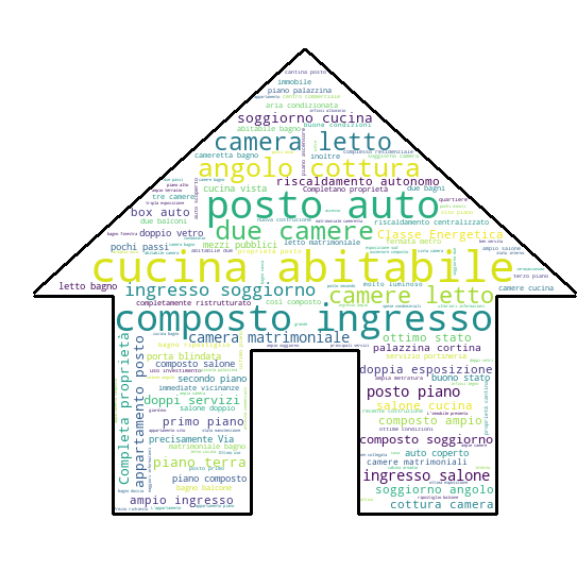

In [396]:
wordcloud_fun(cloud_1)

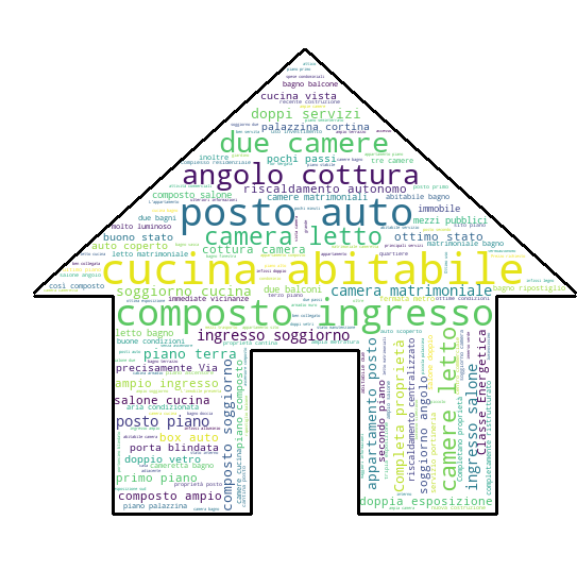

In [397]:
wordcloud_fun(cloud_2)

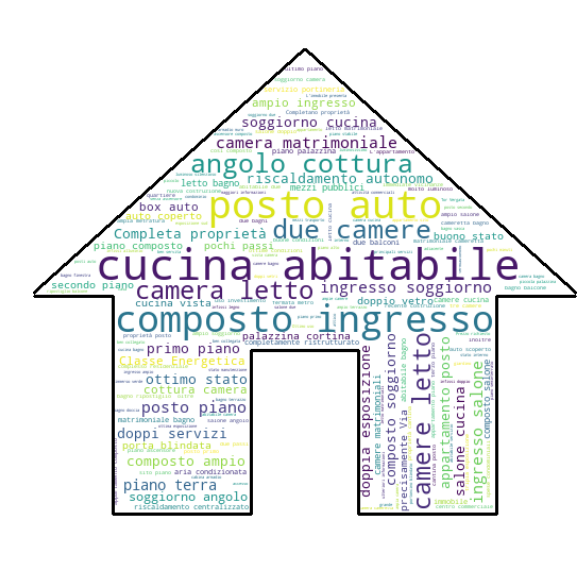

In [398]:
wordcloud_fun(cloud_3)

## Bonus 1

In [74]:
X = tokmean.values
k = 4
selfCluster = {}
myclust = libclust.KMeans(X, k)
selfCluster = myclust.giveCluster()

[295596.50426623377, 812019.5777777778, 123075.3444117647, 46499.707347629796]


In [75]:
dimClusts = {}
for i in range(4):
    dimClusts[i] = len(selfCluster[i])
dimClusts

{0: 616, 1: 54, 2: 2788, 3: 8860}

In [ ]:
np.array(myclust.giveClusterArray())

In [ ]:
dfFeClust['HMCluster'] = np.array(myclust.giveClusterArray())

## Bonus 2 

In [ ]:
findspark.init()
sc = pyspark.SparkContext.getOrCreate()

In [487]:
k = 4
X = tokmean.values
centroids = np.empty([k, X.shape[1]])
for t,i in enumerate(np.random.choice(X.shape[0], k, replace=False)):
    centroids[t] = X[i]

centroids

In [487]:
def kmeansMap(x):
    mindist = float("inf")
    mindistk = 0 
    for j in range(k):
        dist = np.linalg.norm(x-centroids[j])
        if(mindist > dist):
            mindist = dist
            mindistk = j
    
    return (mindistk, x) #(x, 1)

In [ ]:
l = sc.parallelize(X)


In [ ]:
for i in range(300):
    s = l.map(kmeansMap).groupByKey().mapValues(list).collect()
    
    oldcentroids = centroids.copy()
    for i,elem in enumerate(s):
        centroids[i] = np.mean(elem[1], axis=0)
        
    if(np.array_equal(centroids,oldcentroids)):
        print("Number of cycles: ",i, '\n')
        print("Clusters: ",s, '\n')
        print("Centroids: ",centroids)
        break